### Libraries

In [1]:
import numpy
from numpy import pi
import sympy
import math
import scipy
import scipy.optimize
from scipy import constants

import matplotlib.pyplot 

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

### Parameters

In [4]:
# Inputs to Model
Te_eV = 0.63000399999999956 # given in eV
Te = Te_eV*(11604.52500617) # K

Pt = 300 * 133.322 # torr to Pa

#Initial Cathode and Anode Temperatures, assume room temp in Kelvin:
To = 298.15

#Input Arc current
Iarc = 50.

In [5]:


Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]
Lgap = 3.5 * 1./1000. #interelectrode gap [meters]

Rarc = Ran*0.02*Iarc
#Rarc = Ran

Em_C = 0.70 #emissivity - graphite (0-3600 deg)

#Richardson Constant:
A = 1.2e6 #constant in electron current density eqn [A/(m^2 K^2)], pg.62

#Thermal Conductivity Carbon
lmbda_C = 1.7 #thermal conductivity carbon W m-1 K-1

#Work Function, http://hyperphysics.phy-astr.gsu.edu/hbase/tables/photoelec.html
phi_C = 4.81*constants.e #work function of Carbon for photoelectric effect, eV to Joules
phi_C_eV = 4.81 #eV

#Ionization Potential of Carbon
Uiz_C_eV = 11.2603 #eV

dH = (355.8/(0.012))*1000. #convert kJ/Kmol to J/kg, heat of vaporization carbon
dH2 = 5.95e7 #J/Kg http://www.wolframalpha.com/input/?i=heat+of+evaporationcarbon
cp = 710.0 # J/(Kg*K) #specific heat @ constant pressure

E_C = 11.2603*constants.e #ionization energy for carbon in Joules
E_C2 = 24.3833*constants.e #ionization energy for carbon in Joules second spectra
#-------------------------------------------------------------------------------------


In [6]:
UAMU = 1.660538921e-27 # Unified atomic mass unit in Kg

mi_He = UAMU*4.002602
mi_C = UAMU*12.0107

m_i_AMU = (mi_He + mi_C) # given in kilograms
#m_i_AMU = (mi_C)
#
print('mass of He and C Ions : %.4g ' % m_i_AMU)

mass of He and C Ions : 2.659e-26 


### one-species plasma

In [7]:
def get_ne_s1(T_el, e_iz, P_total):
    #
    ne_var = sympy.symbols('ne_var')
    #Saha Eqn
    f_c =  ( ( (2*pi*constants.m_e*constants.k*T_el) / (constants.h**2) )**(3/2) ) *\
                 math.exp( (-e_iz) / (constants.k*T_el))
    #
    ne_var_eqn = sympy.Eq(0, ((ne_var**2 )/f_c) + (2*ne_var) -\
                          (P_total/(T_el*constants.k)) )
    #solve for number density:
    nes = sympy.solve(ne_var_eqn, ne_var)
    nos = (nes[1]**2)/f_c
    nis = nes[1]
    #
    return nes[1], nos, nis

In [8]:
ne, no, ni = get_ne_s1(Te, E_C, Pt)

In [9]:
no

3.89871015598325e+23

In [10]:
ne

3.18944847623742e+21

### Ion Current

In [11]:
I_ion = numpy.pi*(Rc**2)*\
            0.6*(constants.e)*(ne)*numpy.sqrt( (Te_eV*constants.e) / m_i_AMU)
print('Ion Current in Amperes : %.4g ' % I_ion)

Ion Current in Amperes : 73.31 


In [12]:
I_ion/Iarc

1.46615195349806

### Cathode Temperature

In [13]:
def get_T_cathode(Iarc, root):
    Tc = sympy.symbols('Tc')
    Tc_eqn = sympy.Eq( Iarc, pi*(Rc**2)*A*(Tc**2)*sympy.exp(-phi_C/(constants.k*Tc))\
                  + I_ion ) 
    Tcs = sympy.nsolve(Tc_eqn, Tc, root, verify=False)
    Tc_sim = float(Tcs)
    
    return Tc_sim

In [14]:
Tc = sympy.symbols('Tc')

In [15]:
Tc_eqn = sympy.Eq( Iarc, pi*(Rc**2)*A*(Tc**2)*sympy.exp(-phi_C/(constants.k*Tc))\
                  + I_ion ) 

In [16]:
Tc_eqn

50.0 == 147.262155637022*Tc**2*exp(-55817.737846511/Tc) + 73.307597674903

In [17]:
Tcs = sympy.nsolve(Tc_eqn, Tc, 3000, verify=False)

In [18]:
Tc_sim = float(Tcs)

print('Cathode Temperature in Kelvin: %.4g ' % Tc_sim)

Cathode Temperature in Kelvin: 3145 


### Electron Current

In [19]:
I_e = numpy.pi*(Rc**2)*A*(Tc_sim**2)*numpy.exp(-phi_C/(constants.k*Tc_sim))
print('Electron Current in Amperes : %.4g ' % I_e)

Electron Current in Amperes : 28.6 


In [20]:
#check continuity
I_cons = ((I_e + I_ion)/Iarc)*100.
print('Current Continuity Conservation (percent) : %.4g ' % I_cons)

Current Continuity Conservation (percent) : 203.8 


### Anode Region

In [21]:
Ta = sympy.symbols('Ta')

In [22]:

I_th2 = 0.25*constants.e*(ne)*(numpy.sqrt((8*constants.e*Te_eV)/(numpy.pi*constants.m_e)))*pi*Ran**2
print('Thermal Current (Amps): %.4g ' % I_th2)

Thermal Current (Amps): 2149 


In [23]:
Ua_eV =  - Te_eV * math.log(I_th2/Iarc) #eV
print('Anode Voltage drop in eV: %.4g ' % Ua_eV)

Anode Voltage drop in eV: -2.369 


### HEat Flux Density at Anode

In [24]:
q_a = (Iarc/(pi*Ran**2))*((2.*Te_eV + Ua_eV + phi_C_eV))
print('Anode Heat Flux density [ W/m2 ]: %.4g ' % q_a)

Anode Heat Flux density [ W/m2 ]: 5.843e+06 


### Solve for Ta

In [25]:
dH = (355.8/(0.012))*1000. #convert kJ/Kmol to J/kg, heat of vaporization carbon
dH2 = 5.95e7 #J/Kg http://www.wolframalpha.com/input/?i=heat+of+evaporationcarbon
cp = 710.0 # J/(Kg*K) #specific heat @ constant pressure

A = 15.73
B = 40030.0

In [26]:
def get_Ta(m_i, root, hv, c_p, qa, Ti):
    #
    Ta = sympy.symbols('Ta')
    #
    Ta_eqn = qa - ( (0.133*sympy.exp(2.3*(A - B/Ta)))*\
                              sympy.sqrt(m_i/(2*pi*constants.k*Ta)))*\
                   (c_p*Ta + hv+ c_p*(Ta-Ti))
    #
    Ta_sol = sympy.nsolve(Ta_eqn, root, verify=False)
    #
    Ta_sim = float(Ta_sol)
    #
    return Ta_sim

In [27]:
Tan = get_Ta(m_i_AMU, 3000, dH, cp, q_a, To)
Tan

3308.3182477177797

In [28]:
ABL = (0.133*numpy.exp(2.3*(A - B/Tan)))*\
        numpy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*Tan))*\
        numpy.pi*(Ran**2)*1e6
print('Ablation Rate from Anode in [kg/(s)]: %.4g ' % ABL)

Ablation Rate from Anode in [kg/(s)]: 5.421 


### Collisions

In [29]:
# Parameters for Collisions
re = 2.8179403267e-15 # classical electron radius in meters
gamma = numpy.exp(0.577) #from Euler's constant
ni_C = ne #plasma quasi-neutrality
#------------
Qm = 40e-20


ke = math.sqrt((4*numpy.pi*ne*(constants.e**2))/(Te*constants.k))

lnA = numpy.log((4*constants.k*Te)/((gamma**2)*(ke)*(constants.e**2))) -\
        2*numpy.log(numpy.sqrt(2))

# electron-neutral collision frequency
v_eo = (4/3)*numpy.sqrt((8*constants.k*Te)/(numpy.pi*constants.m_e))*\
                Qm*(no)

# electron-neutral collision frequency
v_ei = (4/3)*numpy.sqrt(2*numpy.pi)*(ni_C)*\
            (((constants.e**2)/(constants.k*Te))**2)*\
            numpy.sqrt((constants.k*Te)/constants.m_e)*lnA
        

ve_t = v_ei + v_eo

In [30]:
print('Electron Collision Frequency [1/s]: %.4g ' % ve_t)

Electron Collision Frequency [1/s]: 1.105e+11 


### Electrical Conductivity

In [31]:
# electrical conductivity:

sigma = (ne*constants.e**2)/(constants.m_e* ve_t)

print('Electrical Conductivity of plasma [Siemens/meter]: %.4g ' % sigma)

Electrical Conductivity of plasma [Siemens/meter]: 813.7 


### Inter-electrode Voltage 

In [32]:
Upl = (Iarc*Lgap)/(sigma*numpy.pi*Rarc**2)
print('Interelectrode Voltage [V]: %.4g ' % Upl)

Interelectrode Voltage [V]: 6.791 


### Heat Losses due to Thermal and Radiative conduction

In [33]:
# thermal conduction flux (W/m2)
q_con = ((Tc_sim-To)*lmbda_C)/(Rc*(numpy.pi**(3/2)) )

# radiative  flux (W/m2)
q_rad = Em_C*constants.sigma*(Tc_sim**4)

In [34]:
print('Radiative flux [W/m2]: %.4g ' % q_rad)

Radiative flux [W/m2]: 3.885e+06 


In [35]:
print('Thermal conduction flux [W/m2]: %.4g ' % q_con)

Thermal conduction flux [W/m2]: 1.391e+05 


### Cathode Voltage

In [36]:
Uc = ((numpy.pi*(Rc**2))/(I_ion))*( q_con + q_rad ) + phi_C_eV + Uiz_C_eV

print(' Cathode Voltage in Volts : %.4g ' % Uc)

 Cathode Voltage in Volts : 22.81 


### Energy Conservation

In [37]:
J_Heating = Iarc*(Upl) + Uc*I_e
J_Heating

991.902639096445

In [38]:
# Losses

# Convert anode temp to eV
Ta_sim_eV = Tan/(11604.52500617)
Ta_sim_eV

loss12 = Iarc*(2*Te_eV + Ua_eV) + Uiz_C_eV*I_ion

loss3 = 3*(constants.m_e/m_i_AMU)*\
            (Te_eV-Ta_sim_eV)*ne*Lgap*numpy.pi*(Ran**2)*ve_t*constants.e

In [39]:
loss12+loss3

991.767343255694

In [40]:
cons = J_Heating/(loss12 + loss3)
cons

1.00013641893098

In [41]:
numpy.abs(1 - cons)

0.000136418930982485

## Results

### 99.99 percent convergence achieved for the following trials

### 20 amps, 300 torr: 
#### Te = 0.551819999999992

### 40 amps, 300 torr: 
#### Te = 0.5885799999999872

### 60 amps, 300 torr: 
#### Te = 0.60771000000000541

### 80 Amps, 300 Torr: 
#### Te = 0.61915062499999995

### 100 Amps, 300 Torr: 
#### Te = 0.62941999999999543

In [43]:
Iarc_v = numpy.array((20,40,50,60,80,100), dtype=float)
ne_v = 1e20 * numpy.array((8.75,16.8,31.9,22.8,27.2,31.6), dtype=float)
Iion_v1 = numpy.array((.94,.93,1.46,0.8589,0.7743,0.7265), dtype=float)
Uc_v =  numpy.array((30.68,24.6,22.81,23.66,23.36,22.81), dtype=float)
Ua_v =  -1*numpy.array((1.831,1.947,2.369,1.961,1.933,1.925), dtype=float)
Upl_v =  numpy.array((10.71,10.77,6.791,8.09,5.036,3.426), dtype=float)
Te_v =  numpy.array((0.55182,0.58858,0.63,0.60771,0.6106,0.62942), dtype=float)

Tc_v =  numpy.array((2705,2808,3145,2962,3074,3138), dtype=float)
Ta_v =  numpy.array((3212,3292,3308,3341,3379,3408), dtype=float)

abl_v =  numpy.array((2.402,4.737,5.421,7.135,9.616,12.09), dtype=float)

In [46]:
def plot(v1, v2, xlabl, ylabl, title):
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)

    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

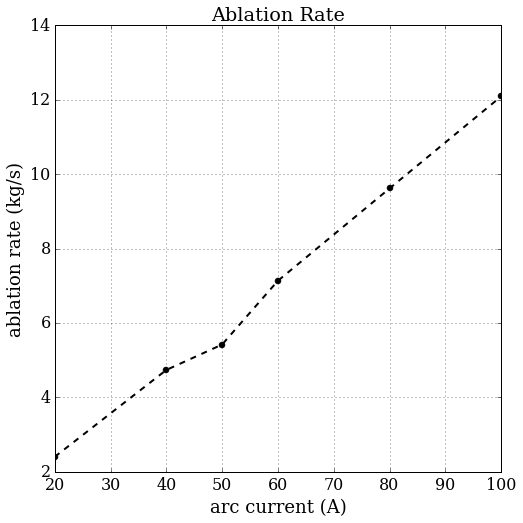

In [49]:
plot(Iarc_v, abl_v, 'arc current (A)',\
     'ablation rate (kg/s)', 'Ablation Rate')

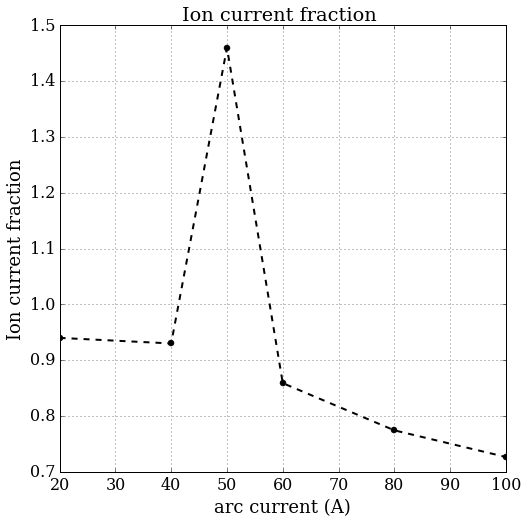

In [50]:
plot(Iarc_v, Iion_v1, 'arc current (A)',\
     'Ion current fraction', 'Ion current fraction ')

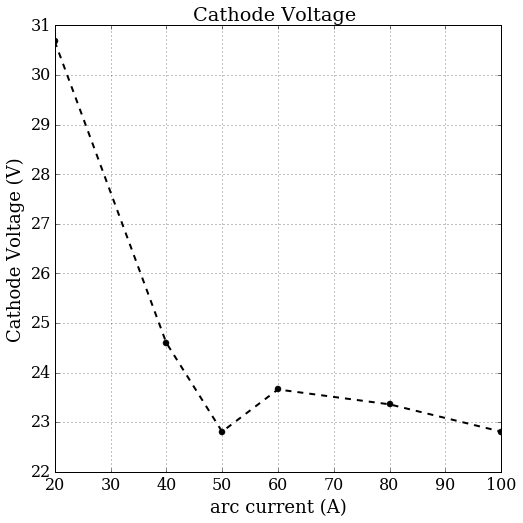

In [51]:
plot(Iarc_v, Uc_v, 'arc current (A)',\
     'Cathode Voltage (V)', 'Cathode Voltage ')

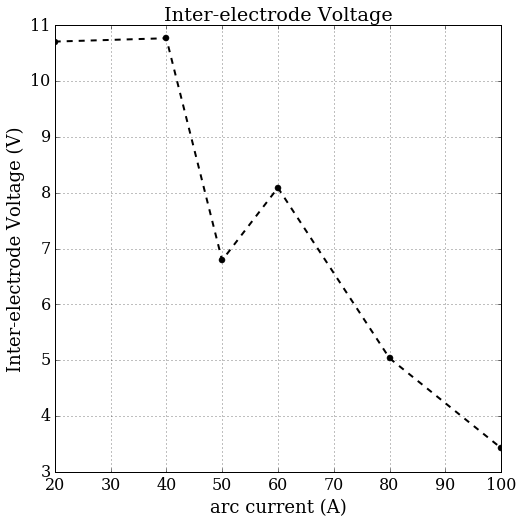

In [52]:
plot(Iarc_v, Upl_v, 'arc current (A)',\
     'Inter-electrode Voltage (V)', 'Inter-electrode Voltage')

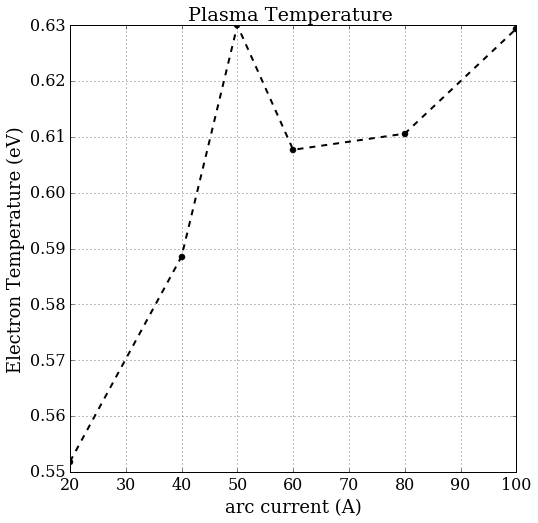

In [53]:
plot(Iarc_v, Te_v, 'arc current (A)',\
     'Electron Temperature (eV)', 'Plasma Temperature ')

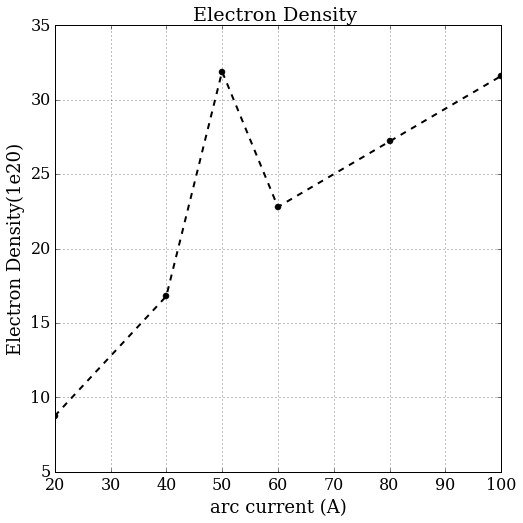

In [56]:
plot(Iarc_v, ne_v/1e20, 'arc current (A)',\
     'Electron Density(1e20)', 'Electron Density ')